<img src="img/ibidat.png" alt="drawing" width="600"/>

# Introducción

En este cuaderno vamos a hacer un estudio de simulación probando todas las parejas posibles de métodos de fairness que afecten a distintas partes del proceso de la construcción del algoritmo de machine learning con un dataset simulado en el que hay un solo atributo sensible.

# Carga de librerías


In [1]:
# Con esta celda, podemos hacer cambios en cualquier script/libreria y verlo reflejado en las funciones del notebook.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## CARGAMOS LIBRERIAS
# Obs: La primera vez puede tardar en cargar porque AIF360 pre-compila algunas cosas de tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargamos librerías de sklearn
# vanilla LR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Cargamos xgboost
from xgboost import XGBClassifier

# Cargamos algoritmos de fairness
# Pre-procesado
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
# In-procesado
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing import MetaFairClassifier
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
# Post-procesado
from aif360.algorithms.postprocessing import RejectOptionClassification # when scores are given
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing # when scores (R) are given
from aif360.algorithms.postprocessing import EqOddsPostprocessing # when labels (Y^hat) are given
from aif360.datasets import GermanDataset

#Simulacion
from aif360.datasets import BinaryLabelDataset

# TF para adversarial debiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from IPython.display import Markdown, display

# Librería local con funciones de ayuda extra
import utils

seed = 12345 # fijamos la semilla de números aleatorios para reproducir exactamante el notebook
np.random.seed(seed)

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

# Simulación de dataset.

El siguiente bloque permite generar el conjunto de datos sobre el que vamos a trabajar.


In [3]:
def logit(x):
    return np.log(x/(1-x))

def inv_logit(x):
    return np.exp(x)/(1+np.exp(x))

def simulated_dataset(n_obs, n_var, n_sens, mean_vec, cov, beta, gamma):
    
    p = n_var + n_sens
    coef = np.concatenate((gamma, beta))
        
    X = np.random.multivariate_normal(mean_vec, cov, size = n_obs)
    probs_var = inv_logit(X)
    bin = np.random.binomial(1, probs_var)
    
    probs_Y = inv_logit(coef.dot(X.T))
    Y = np.random.binomial(1, probs_Y)
    
    names = ['0' for i in range(p+1)]
    sens = ['0' for i in range(n_sens)]
    var = 1
    
    names[0] = 'response'
    
    for i in range(1,p+1):
        if i-1 < n_sens:
            sens[i-1] = 'sens ' + str(i)
            names[i] = 'sens ' + str(i)
        if i-1 >= n_sens:
            names[i] = 'var ' + str(var)
            var += 1
    
    names = np.array(names)
    sens = np.array(sens)
    response = np.array(['response'])
    
    Y = Y.reshape((n_obs,1))
    
    bin = np.concatenate((Y, bin), axis = 1)
    
    data_pd = pd.DataFrame(bin, columns = names)
    data = BinaryLabelDataset(df = data_pd, favorable_label = 1, unfavorable_label = 0, label_names = response, protected_attribute_names = sens)
    return data

In [4]:
n_obs = 1000
n_var = 30
n_sens = 1
mean_vec = np.zeros(n_var+n_sens)
cov = np.identity(n_var+n_sens)
beta = np.ones(n_var)
gamma = np.zeros(n_sens)

dataset = simulated_dataset(n_obs, n_var, n_sens, mean_vec, cov, beta, gamma)

#dataset.favorable_label = 1
#dataset.unfavorable_label = 0

# Separamos el conjunto de datos en train, validate, test
data_train, vt = dataset.split([0.7], shuffle=True, seed=seed)
data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

# Obtenemos los indicadores del grupo sensible
sensitive_attribute = dataset.protected_attribute_names[0]
privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset)
    
print(f'Dimensiones del conjunto de datos: {dataset.features.shape}')
print("Grupos privilegiados:", privileged_groups)
print("Grupos no privilegiados:", unprivileged_groups)
print("Label del grupo favorable:", dataset.favorable_label)
print("Label del grupo desfavorable:", dataset.unfavorable_label)

Dimensiones del conjunto de datos: (1000, 31)
Grupos privilegiados: [{'sens 1': 1.0}]
Grupos no privilegiados: [{'sens 1': 0.0}]
Label del grupo favorable: 1.0
Label del grupo desfavorable: 0.0


## Modelos
Para esta sección, creamos un diccionario de métricas y modelos para poder acceder los resultados de todos los modelos.

In [5]:
# Inicializamos diccionarios
models = dict()

# Rango de umbrales para evaluar el score de los modelos
thresh_sweep = np.linspace(0.01, 1.0, 50)

metrics_sweep = dict()

# Store results from validation and test
metrics_best_thresh_validate = dict()
metrics_best_thresh_test = dict()

### Regresión Logística

In [6]:
%%time 

# Nombramos al modelo
model_name = 'logistic_regression'
fairness_method = ''

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

CPU times: user 6.24 ms, sys: 993 µs, total: 7.23 ms
Wall time: 20.8 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5405
Balanced accuracy: 0.5425
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.0187
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0345
Sufficiency ( |ΔPPV| ) : 0.1266
CPU times: user 190 ms, sys: 30.2 ms, total: 221 ms
Wall time: 544 ms


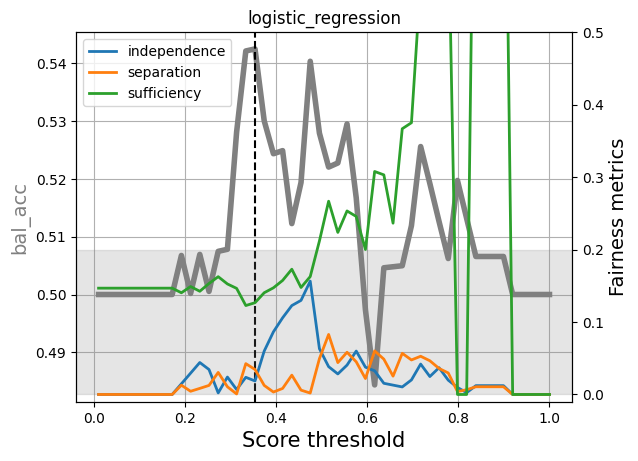

In [7]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [8]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.6998
Balanced accuracy: 0.5982
Accuracy: 0.5800
Independence ( |ΔP(Y_pred = 1)| ): 0.1461
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0726
Sufficiency ( |ΔPPV| ) : 0.1637


### XGBoost

In [9]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'
fairness_method = ''

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

CPU times: user 1h 8min 17s, sys: 3.08 s, total: 1h 8min 20s
Wall time: 11min 24s


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5740
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0047
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0139
Sufficiency ( |ΔPPV| ) : 0.1325
CPU times: user 3.02 s, sys: 32 ms, total: 3.05 s
Wall time: 1.08 s


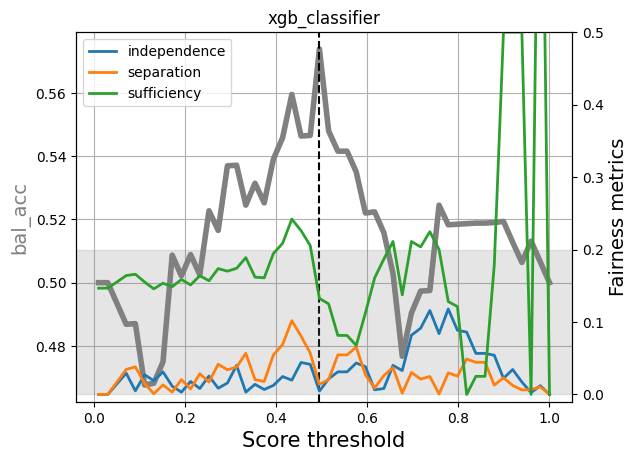

In [10]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


In [11]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5932
Balanced accuracy: 0.5768
Accuracy: 0.5800
Independence ( |ΔP(Y_pred = 1)| ): 0.1223
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0323
Sufficiency ( |ΔPPV| ) : 0.1658


## Técnicas de preprocesado

### Reponderación

In [12]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit(data_train_copy)
data_train_REW = PreProcessor.transform(data_train_copy)
data_val_REW = PreProcessor.transform(data_val_copy)
data_test_REW = PreProcessor.transform(data_test_copy)

CPU times: user 7.84 ms, sys: 0 ns, total: 7.84 ms
Wall time: 13.6 ms


De aquí en adelante, se aplica el modelo de preferencia de manera estándar

### Eliminador de impacto dispar

In [13]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
nivel_reparacion = 0.5 # un valor 0 inidica ausencia de reparación (datos se mantienen igual) 
                       # un valor 1 indica reparación completa (se puede perder nivel predictivo).
                       # Se puede establecer cualquier valor entre 0 y 1.

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = DisparateImpactRemover(
    repair_level=nivel_reparacion,
    sensitive_attribute=sensitive_attribute
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit_transform(data_train_copy)
data_train_DIR = PreProcessor.fit_transform(data_train_copy)
data_val_DIR = PreProcessor.fit_transform(data_val_copy)
data_test_DIR = PreProcessor.fit_transform(data_test_copy)



CPU times: user 206 ms, sys: 4.01 ms, total: 210 ms
Wall time: 781 ms


## Entrenamiento de técnicas de inprocesado

Entrenamos ahora los algoritmos de inprocesado para aplicarlos posteriormente cuando hagan falta.

### Eliminador de prejuicios por regularización

In [14]:
%%time 
# Nombramos al modelo
model_name = 'prejudice_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [15]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

### Algoritmo de metafairness

In [16]:
%%time 
# Nombramos al modelo
model_name = 'meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )
    models[model_name_quality].scores_train = models[model_name_quality].predict(data_train_copy).scores
    models[model_name_quality].scores_val = models[model_name_quality].predict(data_val_copy).scores
    models[model_name_quality].scores_test = models[model_name_quality].predict(data_test_copy).scores

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:36: RuntimeWarning: invalid value encountered in divide
  prob_y_1 = (prob_1_1 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:37: RuntimeWarning: invalid value encountered in divide
  prob_z_0 = (prob_m1_0 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:38: RuntimeWarning: invalid value encountered in divide
  prob_z_1 = (prob_m1_1 + prob_1_1) / total


TypeError: cannot unpack non-iterable NoneType object

In [17]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep(
        dataset=data_val_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics(
        dataset=data_test_copy, 
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for meta_fairness_sr


AttributeError: 'MetaFairClassifier' object has no attribute 'model'

### Eliminación de prejuicios adversarios

In [18]:
%%time

# Nombramos al modelo
model_name = 'NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

2024-06-14 08:25:46.748327: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2024-06-14 08:25:47.755773: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 0.744105; batch adversarial loss: 0.713970
epoch 1; iter: 0; batch classifier loss: 0.690153; batch adversarial loss: 0.706501
epoch 2; iter: 0; batch classifier loss: 0.696660; batch adversarial loss: 0.777555
epoch 3; iter: 0; batch classifier loss: 0.692590; batch adversarial loss: 0.755478
epoch 4; iter: 0; batch classifier loss: 0.680635; batch adversarial loss: 0.738805
epoch 5; iter: 0; batch classifier loss: 0.688001; batch adversarial loss: 0.725242
epoch 6; iter: 0; batch classifier loss: 0.681196; batch adversarial loss: 0.778612
epoch 7; iter: 0; batch classifier loss: 0.676553; batch adversarial loss: 0.756587
epoch 8; iter: 0; batch classifier loss: 0.678415; batch adversarial loss: 0.753371
epoch 9; iter: 0; batch classifier loss: 0.669034; batch adversarial loss: 0.761764
epoch 10; iter: 0; batch classifier loss: 0.685406; batch adversarial loss: 0.748950
epoch 11; iter: 0; batch classifier loss: 0.672687; batch adversarial loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.4141
AUC: 0.5994
Balanced accuracy: 0.5976
Accuracy: 0.6000
Independence ( |ΔP(Y_pred = 1)| ): 0.5983
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0509
Sufficiency ( |ΔPPV| ) : 0.0481
CPU times: user 361 ms, sys: 461 ms, total: 822 ms
Wall time: 661 ms


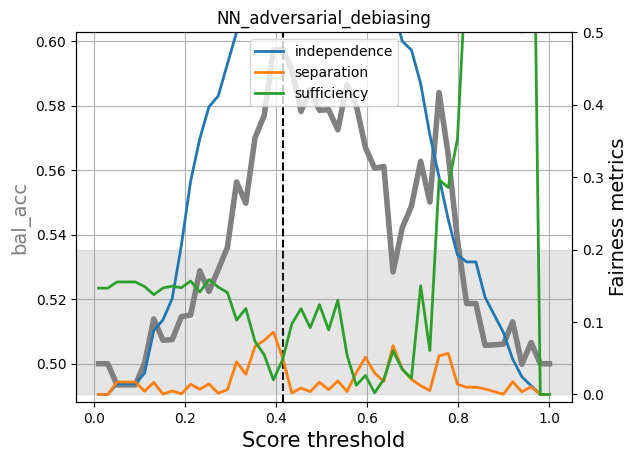

In [19]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

#### Eliminación de prejuicios adversarios: Red neuronal sin eliminación de prejuicios 

In [20]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'Basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

epoch 0; iter: 0; batch classifier loss: 0.708579
epoch 1; iter: 0; batch classifier loss: 0.708955
epoch 2; iter: 0; batch classifier loss: 0.669421
epoch 3; iter: 0; batch classifier loss: 0.681439
epoch 4; iter: 0; batch classifier loss: 0.680147
epoch 5; iter: 0; batch classifier loss: 0.680275
epoch 6; iter: 0; batch classifier loss: 0.636913
epoch 7; iter: 0; batch classifier loss: 0.651361
epoch 8; iter: 0; batch classifier loss: 0.666430
epoch 9; iter: 0; batch classifier loss: 0.655140
epoch 10; iter: 0; batch classifier loss: 0.647285
epoch 11; iter: 0; batch classifier loss: 0.619546
epoch 12; iter: 0; batch classifier loss: 0.625488
epoch 13; iter: 0; batch classifier loss: 0.609579
epoch 14; iter: 0; batch classifier loss: 0.644327
epoch 15; iter: 0; batch classifier loss: 0.638136
epoch 16; iter: 0; batch classifier loss: 0.610953
epoch 17; iter: 0; batch classifier loss: 0.632899
epoch 18; iter: 0; batch classifier loss: 0.595215
epoch 19; iter: 0; batch classifier loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5516
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.0520
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0590
Sufficiency ( |ΔPPV| ) : 0.1956
CPU times: user 196 ms, sys: 36.1 ms, total: 232 ms
Wall time: 761 ms


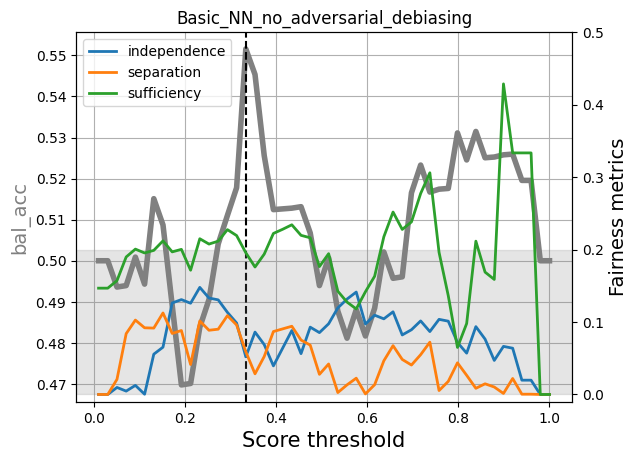

In [21]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Preprocesado + Inprocesado

### Reponderación + Eliminador de prejuicios

In [22]:
# Nombre del modelo
model_name = 'reweighting_prejudice_remover'

# Hacemos una copia de los datasets (usando uno de lo métodos de pre-procesado vistos anteriormente)
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [ ]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + Eliminador de prejuicios

In [ ]:
# Nombre del modelo
model_name = 'disparate_impact_prejudice_remover'

# Hacemos una copia de los datasets (usando uno de lo métodos de pre-procesado vistos anteriormente)
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

In [ ]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Reponderación + metafairness

In [23]:
%%time 
# Nombramos al modelo
model_name = 'reweighing_meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:36: RuntimeWarning: invalid value encountered in divide
  prob_y_1 = (prob_1_1 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:37: RuntimeWarning: invalid value encountered in divide
  prob_z_0 = (prob_m1_0 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:38: RuntimeWarning: invalid value encountered in divide
  prob_z_1 = (prob_m1_1 + prob_1_1) / total


TypeError: cannot unpack non-iterable NoneType object

In [24]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep(
        dataset=data_val_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics(
        dataset=data_test_copy, 
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for reweighing_meta_fairness_sr


AttributeError: 'MetaFairClassifier' object has no attribute 'model'

### Impacto dispar + metafairness

In [25]:
%%time 
# Nombramos al modelo
model_name = 'disparate_impact_meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

TypeError: cannot unpack non-iterable NoneType object

In [26]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep(
        dataset=data_val_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics(
        dataset=data_test_copy, 
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for disparate_impact_meta_fairness_sr


AttributeError: 'MetaFairClassifier' object has no attribute 'model'

### Reponderación + prejuicios adversarios

In [27]:
%%time

# Nombramos al modelo
model_name = 'reweighing_NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.697925; batch adversarial loss: 0.694265
epoch 1; iter: 0; batch classifier loss: 0.688857; batch adversarial loss: 0.711633
epoch 2; iter: 0; batch classifier loss: 0.680499; batch adversarial loss: 0.737359
epoch 3; iter: 0; batch classifier loss: 0.663034; batch adversarial loss: 0.767976
epoch 4; iter: 0; batch classifier loss: 0.694542; batch adversarial loss: 0.741932
epoch 5; iter: 0; batch classifier loss: 0.664982; batch adversarial loss: 0.705042
epoch 6; iter: 0; batch classifier loss: 0.658878; batch adversarial loss: 0.706844
epoch 7; iter: 0; batch classifier loss: 0.674519; batch adversarial loss: 0.706490
epoch 8; iter: 0; batch classifier loss: 0.679956; batch adversarial loss: 0.757508
epoch 9; iter: 0; batch classifier loss: 0.664824; batch adversarial loss: 0.738512
epoch 10; iter: 0; batch classifier loss: 0.676319; batch adversarial loss: 0.724480
epoch 11; iter: 0; batch classifier loss: 0.663974; batch adversarial loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.4545
AUC: 0.5203
Balanced accuracy: 0.5315
Accuracy: 0.5318
Independence ( |ΔP(Y_pred = 1)| ): 0.2100
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0676
Sufficiency ( |ΔPPV| ) : 0.3025
CPU times: user 320 ms, sys: 317 ms, total: 636 ms
Wall time: 232 ms


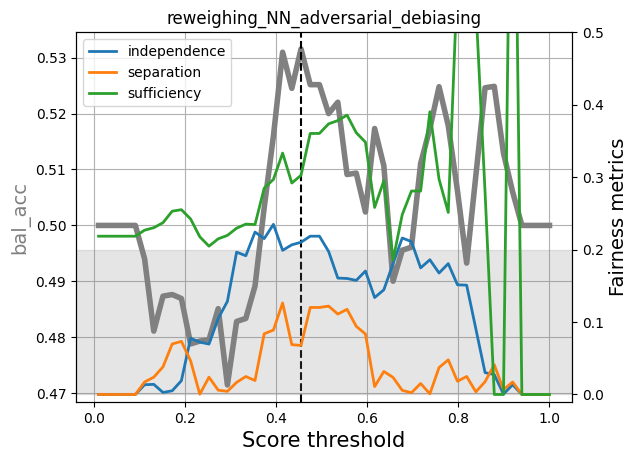

In [28]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Reponderación + red neuronal normal

In [29]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'reweighin_basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.743564
epoch 1; iter: 0; batch classifier loss: 0.679191
epoch 2; iter: 0; batch classifier loss: 0.679958
epoch 3; iter: 0; batch classifier loss: 0.670818
epoch 4; iter: 0; batch classifier loss: 0.673950
epoch 5; iter: 0; batch classifier loss: 0.676322
epoch 6; iter: 0; batch classifier loss: 0.645758
epoch 7; iter: 0; batch classifier loss: 0.632254
epoch 8; iter: 0; batch classifier loss: 0.662272
epoch 9; iter: 0; batch classifier loss: 0.637185
epoch 10; iter: 0; batch classifier loss: 0.617198
epoch 11; iter: 0; batch classifier loss: 0.613527
epoch 12; iter: 0; batch classifier loss: 0.639275
epoch 13; iter: 0; batch classifier loss: 0.639707
epoch 14; iter: 0; batch classifier loss: 0.651122
epoch 15; iter: 0; batch classifier loss: 0.621743
epoch 16; iter: 0; batch classifier loss: 0.614965
epoch 17; iter: 0; batch classifier loss: 0.618761
epoch 18; iter: 0; batch classifier loss: 0.593653
epoch 19; iter: 0; batch classifier loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.5555
AUC: 0.5309
Balanced accuracy: 0.5452
Accuracy: 0.5418
Independence ( |ΔP(Y_pred = 1)| ): 0.0819
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0534
Sufficiency ( |ΔPPV| ) : 0.3131
CPU times: user 202 ms, sys: 8.03 ms, total: 210 ms
Wall time: 198 ms


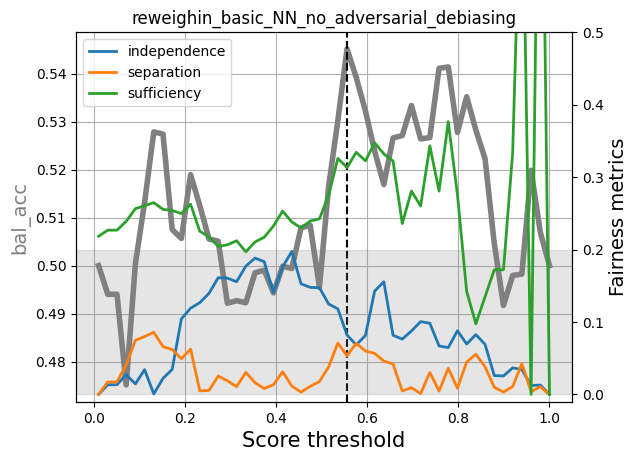

In [30]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + eliminación de prejuicios adversarios

In [31]:
%%time

# Nombramos al modelo
model_name = 'disparate_impact_NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.704826; batch adversarial loss: 0.757036
epoch 1; iter: 0; batch classifier loss: 0.687862; batch adversarial loss: 0.776310
epoch 2; iter: 0; batch classifier loss: 0.675010; batch adversarial loss: 0.708354
epoch 3; iter: 0; batch classifier loss: 0.701930; batch adversarial loss: 0.702527
epoch 4; iter: 0; batch classifier loss: 0.676581; batch adversarial loss: 0.696413
epoch 5; iter: 0; batch classifier loss: 0.658618; batch adversarial loss: 0.707433
epoch 6; iter: 0; batch classifier loss: 0.670687; batch adversarial loss: 0.724893
epoch 7; iter: 0; batch classifier loss: 0.678489; batch adversarial loss: 0.729444
epoch 8; iter: 0; batch classifier loss: 0.656670; batch adversarial loss: 0.752046
epoch 9; iter: 0; batch classifier loss: 0.663122; batch adversarial loss: 0.729398
epoch 10; iter: 0; batch classifier loss: 0.639920; batch adversarial loss: 0.694124
epoch 11; iter: 0; batch classifier loss: 0.676759; batch adversarial loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.5353
AUC: 0.5236
Balanced accuracy: 0.5482
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.0348
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0117
Sufficiency ( |ΔPPV| ) : 0.1564
CPU times: user 365 ms, sys: 68.2 ms, total: 433 ms
Wall time: 422 ms


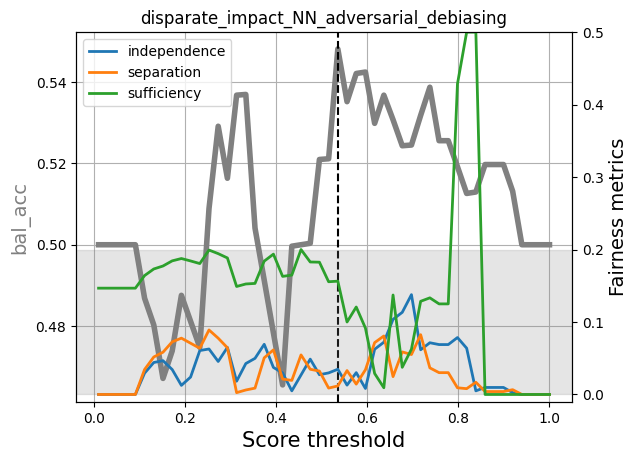

In [32]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + red neuronal normal

In [33]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'disparate_impact_basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.701412
epoch 1; iter: 0; batch classifier loss: 0.699440
epoch 2; iter: 0; batch classifier loss: 0.707696
epoch 3; iter: 0; batch classifier loss: 0.661452
epoch 4; iter: 0; batch classifier loss: 0.647131
epoch 5; iter: 0; batch classifier loss: 0.654733
epoch 6; iter: 0; batch classifier loss: 0.679139
epoch 7; iter: 0; batch classifier loss: 0.642373
epoch 8; iter: 0; batch classifier loss: 0.666917
epoch 9; iter: 0; batch classifier loss: 0.657582
epoch 10; iter: 0; batch classifier loss: 0.651301
epoch 11; iter: 0; batch classifier loss: 0.623253
epoch 12; iter: 0; batch classifier loss: 0.642528
epoch 13; iter: 0; batch classifier loss: 0.637930
epoch 14; iter: 0; batch classifier loss: 0.627472
epoch 15; iter: 0; batch classifier loss: 0.605341
epoch 16; iter: 0; batch classifier loss: 0.648751
epoch 17; iter: 0; batch classifier loss: 0.619968
epoch 18; iter: 0; batch classifier loss: 0.625381
epoch 19; iter: 0; batch classifier loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.8384
AUC: 0.5400
Balanced accuracy: 0.5782
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0520
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0836
Sufficiency ( |ΔPPV| ) : 0.0404
CPU times: user 195 ms, sys: 8.04 ms, total: 203 ms
Wall time: 189 ms


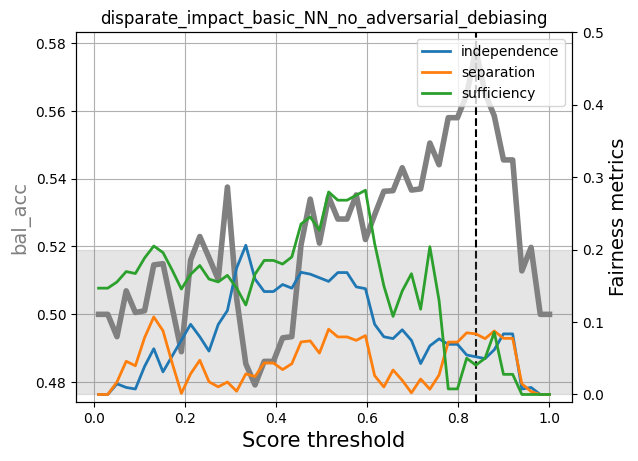

In [34]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Preprocesado + Postprocesado

### Entrenamiento de modelos con técnicas de preprocesado

#### Reponderación

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3131
AUC: 0.5574
Balanced accuracy: 0.5641
Accuracy: 0.5718
Independence ( |ΔP(Y_pred = 1)| ): 0.0970
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0450
Sufficiency ( |ΔPPV| ) : 0.1905


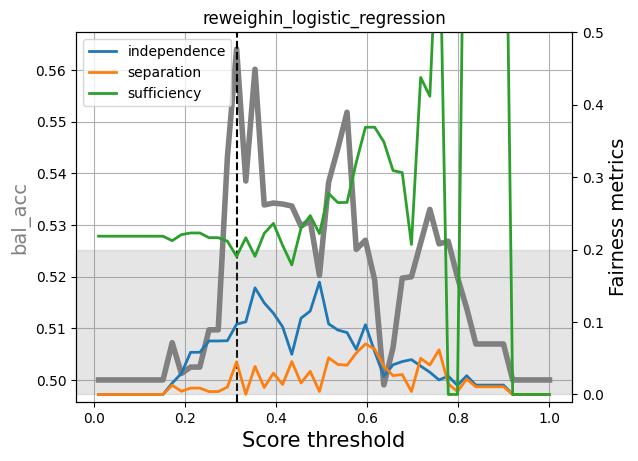

In [35]:
# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

# Regresión logística
model_name = 'reweighin_logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5730
Accuracy: 0.5720
Independence ( |ΔP(Y_pred = 1)| ): 0.0063
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0139
Sufficiency ( |ΔPPV| ) : 0.2027
CPU times: user 1h 3min 40s, sys: 3.12 s, total: 1h 3min 43s
Wall time: 2min 52s


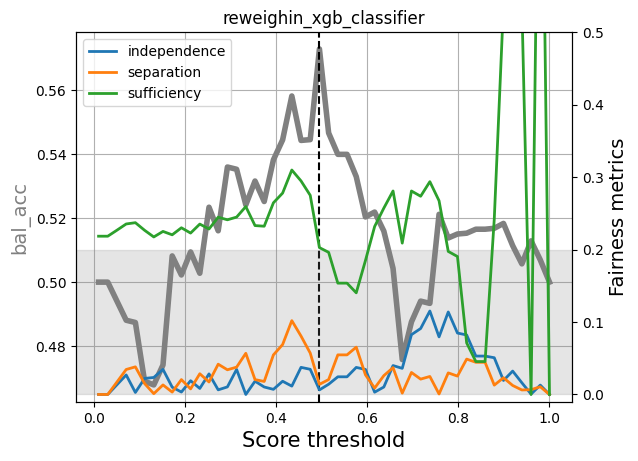

In [36]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

# Nombramos al modelo
model_name = 'reweighin_xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

#### Disparate impact

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5405
Balanced accuracy: 0.5425
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.0187
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0345
Sufficiency ( |ΔPPV| ) : 0.1266


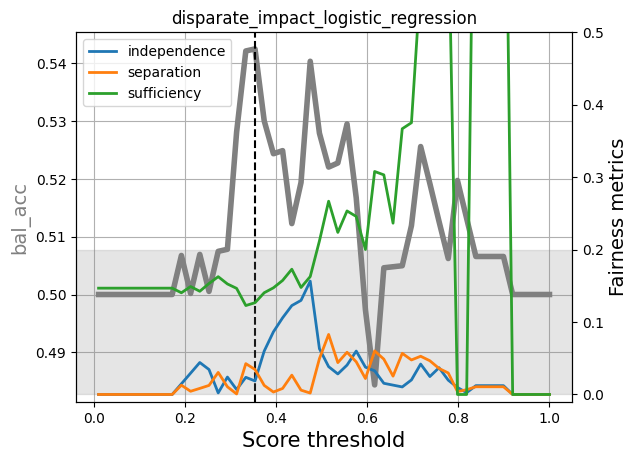

In [37]:
# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

# Regresión logística
model_name = 'disparate_impact_logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5740
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0047
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0139
Sufficiency ( |ΔPPV| ) : 0.1325
CPU times: user 1h 11s, sys: 2.49 s, total: 1h 14s
Wall time: 2min 27s


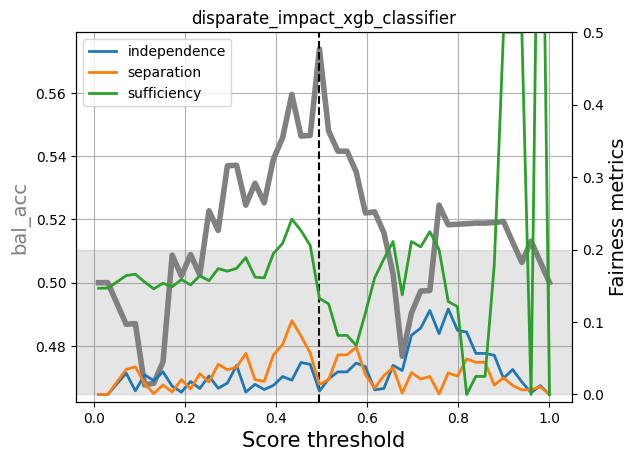

In [38]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)

# Nombramos al modelo
model_name = 'disparate_impact_xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [39]:
#Anotamos los nombres de los modelos
model_names = ['reweighin_logistic_regression', 'reweighin_xgb_classifier', 'disparate_impact_logistic_regression', 'disparate_impact_xgb_classifier']

### Aplicación de técnicas de postprocesado 

#### Reponderación + Clasificación de rechazo de opción

In [40]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 15.1 s, sys: 2.98 s, total: 18.1 s
Wall time: 14.7 s


In [41]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

reweighin_logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.5049
AUC: 0.5574
Balanced accuracy: 0.5149
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.1302
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0078
Sufficiency ( |ΔPPV| ) : 0.1548


reweighin_logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.4258
AUC: 0.5574
Balanced accuracy: 0.5452
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.0728
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0007
Sufficiency ( |ΔPPV| ) : 0.1422


reweighin_logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.5247
AUC: 0.5574
Balanced accuracy: 0.5354
Accuracy: 0.5333
Independence ( |ΔP(Y_pred = 1)| ): 0.0692
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0543
Sufficiency ( |ΔPPV| ) : 0.2166




In [42]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 14.6 s, sys: 112 ms, total: 14.7 s
Wall time: 10.7 s


In [43]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

reweighin_xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5354
Balanced accuracy: 0.4957
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.1011
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0120
Sufficiency ( |ΔPPV| ) : 0.1403


reweighin_xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2575
AUC: 0.5354
Balanced accuracy: 0.5094
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0202
Sufficiency ( |ΔPPV| ) : 0.1590


reweighin_xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2575
AUC: 0.5354
Balanced accuracy: 0.5094
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0202
Sufficiency ( |ΔPPV| ) : 0.1590




#### Impacto dispar + Rechazo de opción

In [44]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 10.4 s, sys: 3.41 s, total: 13.8 s
Wall time: 9.63 s


In [45]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

disparate_impact_logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.5148
AUC: 0.5405
Balanced accuracy: 0.5352
Accuracy: 0.5333
Independence ( |ΔP(Y_pred = 1)| ): 0.0936
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0506
Sufficiency ( |ΔPPV| ) : 0.2078


disparate_impact_logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.4258
AUC: 0.5405
Balanced accuracy: 0.5386
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.0606
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0113
Sufficiency ( |ΔPPV| ) : 0.1346


disparate_impact_logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.5445
AUC: 0.5405
Balanced accuracy: 0.5290
Accuracy: 0.5267
Independence ( |ΔP(Y_pred = 1)| ): 0.0864
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0481
Sufficiency ( |ΔPPV| ) : 0.2123




In [46]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 14.9 s, sys: 117 ms, total: 15 s
Wall time: 10.3 s


In [47]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

disparate_impact_xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5354
Balanced accuracy: 0.4957
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.1011
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0120
Sufficiency ( |ΔPPV| ) : 0.1403


disparate_impact_xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2575
AUC: 0.5354
Balanced accuracy: 0.5094
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0202
Sufficiency ( |ΔPPV| ) : 0.1590


disparate_impact_xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2575
AUC: 0.5354
Balanced accuracy: 0.5094
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0202
Sufficiency ( |ΔPPV| ) : 0.1590




#### Reponderación y impacto dispar + Escalado de Platt por grupos

In [48]:
%%time
fairness_method = '_platt_scaling'
model_names = model_names
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)

for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name], class_thresh = model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                             'unpriv': [data_val_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data.items():

        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()

        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                  data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
        
        # Evaluamos a los modelos para el rango de umbrales
    thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                     np.max(data_val_preds2.scores.ravel()),
                                     50)

    metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores(
            dataset_true = data_val_copy,
            dataset_preds = data_val_preds2,
            thresh_arr = thresh_sweep_platt
        )

    # Evaluamos las métricas para el mejor umbral y las guardamos
    metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    print('\nValidation set results for {}'.format(model_name))
    utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
    # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
    # plt.title( model_name+fairness_method )
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
    a.set_title(model_name+fairness_method )
    f



Validation set results for reweighin_logistic_regression
Threshold corresponding to *best balanced accuracy*: 0.5457
AUC: 0.5967
Balanced accuracy: 0.5864
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.9512
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0322
Sufficiency ( |ΔPPV| ) : 0.5897

Validation set results for reweighin_xgb_classifier
Threshold corresponding to *best balanced accuracy*: 0.5683
AUC: 0.5930
Balanced accuracy: 0.5894
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.5366
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0942
Sufficiency ( |ΔPPV| ) : 0.6591

Validation set results for disparate_impact_logistic_regression
Threshold corresponding to *best balanced accuracy*: 0.5477
AUC: 0.5964
Balanced accuracy: 0.5866
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.9268
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0359
Sufficiency ( |ΔPPV| ) : 0.5921

Validation set results for disparate_impact_xgb_classifier
Threshold corresponding to *best balanced accuracy*: 0.5683
AUC: 0.5930
Balanced

In [49]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name], class_thresh = model_thresh)
    
    # 1. dividir el validation data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
    
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

#### Reponderación + Procesador de probabilidades igualadas

##### Usando labels

In [50]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [51]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [52]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [53]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [54]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 119 ms, sys: 529 ms, total: 648 ms
Wall time: 18.6 ms


In [55]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for reweighin_logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3131
AUC: 0.5574
Balanced accuracy: 0.5615
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.0886
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0450
Sufficiency ( |ΔPPV| ) : 0.1184


Results for reweighin_logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5574
Balanced accuracy: 0.5622
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.1524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0281
Sufficiency ( |ΔPPV| ) : 0.1240


Results for reweighin_logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3131
AUC: 0.5574
Balanced accuracy: 0.5681
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0739
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0623
Sufficiency ( |ΔPPV| ) : 0.1093




In [56]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 5.01 s, sys: 88.7 ms, total: 5.1 s
Wall time: 94 ms


In [57]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for reweighin_xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5740
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0047
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0139
Sufficiency ( |ΔPPV| ) : 0.1325


Results for reweighin_xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5738
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0341
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0184
Sufficiency ( |ΔPPV| ) : 0.1335


Results for reweighin_xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5875
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.0291
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0146
Sufficiency ( |ΔPPV| ) : 0.1696




#### Impacto dispar + Procesador de probabilidades igualadas

##### Usando labels

In [58]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [59]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [60]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [61]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

##### Usando scores

In [62]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 156 ms, sys: 449 ms, total: 605 ms
Wall time: 17.5 ms


In [63]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for disparate_impact_logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.4747
AUC: 0.5405
Balanced accuracy: 0.5471
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.1686
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0123
Sufficiency ( |ΔPPV| ) : 0.1826


Results for disparate_impact_logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.5555
AUC: 0.5405
Balanced accuracy: 0.5514
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.2683
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0596
Sufficiency ( |ΔPPV| ) : 0.6818


Results for disparate_impact_logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5405
Balanced accuracy: 0.5411
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.1765
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0637
Sufficiency ( |ΔPPV| ) : 0.1089




In [64]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 5.11 s, sys: 109 ms, total: 5.22 s
Wall time: 96.8 ms


In [65]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for disparate_impact_xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5740
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0047
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0139
Sufficiency ( |ΔPPV| ) : 0.1325


Results for disparate_impact_xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5738
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0341
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0184
Sufficiency ( |ΔPPV| ) : 0.1335


Results for disparate_impact_xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.5354
Balanced accuracy: 0.5875
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.0291
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0146
Sufficiency ( |ΔPPV| ) : 0.1696




## Inprocesado + Postprocesado

In [66]:
#Anotamos los nombres de los modelos que vamos a usar
model_names = ['prejudice_remover', 'meta_fairness_sr', 'meta_fairness_fdr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']

### Eliminador de prejuicios + rechazo de opción

In [67]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

In [68]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

KeyError: 'prejudice_remover_reject_option_spd'

### Metafairness + rechazo de opción

In [69]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 9.76 s, sys: 180 ms, total: 9.94 s
Wall time: 9.94 s


In [70]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

meta_fairness_sr_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5354
Balanced accuracy: 0.4957
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.1011
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0120
Sufficiency ( |ΔPPV| ) : 0.1403


meta_fairness_sr_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2575
AUC: 0.5354
Balanced accuracy: 0.5094
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0202
Sufficiency ( |ΔPPV| ) : 0.1590


meta_fairness_sr_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2575
AUC: 0.5354
Balanced accuracy: 0.5094
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0202
Sufficiency ( |ΔPPV| ) : 0.1590




### Prejuicios adversarios + rechazo de opción

In [71]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 9.91 s, sys: 241 ms, total: 10.2 s
Wall time: 10.1 s


In [72]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

meta_fairness_fdr_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5354
Balanced accuracy: 0.4957
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.1011
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0120
Sufficiency ( |ΔPPV| ) : 0.1403


meta_fairness_fdr_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2575
AUC: 0.5354
Balanced accuracy: 0.5094
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0202
Sufficiency ( |ΔPPV| ) : 0.1590


meta_fairness_fdr_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2575
AUC: 0.5354
Balanced accuracy: 0.5094
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0202
Sufficiency ( |ΔPPV| ) : 0.1590




### Red neuronal normal + rechazo de opción

In [73]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 12.3 s, sys: 265 ms, total: 12.6 s
Wall time: 12.6 s


In [74]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

NN_adversarial_debiasing_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.2080
AUC: 0.5354
Balanced accuracy: 0.4957
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.1011
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0120
Sufficiency ( |ΔPPV| ) : 0.1403


NN_adversarial_debiasing_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2575
AUC: 0.5354
Balanced accuracy: 0.5094
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0202
Sufficiency ( |ΔPPV| ) : 0.1590


NN_adversarial_debiasing_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2575
AUC: 0.5354
Balanced accuracy: 0.5094
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0524
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0202
Sufficiency ( |ΔPPV| ) : 0.1590




### Inprocesado + Escalado Platt por grupos

In [75]:
%%time
fairness_method = '_platt_scaling'

model_names = ['NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
#model_names = ['meta_fairness_fdr', 'meta_fairness_sr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
#model_names = ['prejudice_remover', 'meta_fairness_sr', 'meta_fairness_fdr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)
    
for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                            'unpriv': [data_val_preds_unpriv, unpriv_indices]}
    
    for group, data_group_list in sensitive_groups_data.items():
    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)
    
        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()
    
        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                      data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
            
        # Evaluamos a los modelos para el rango de umbrales
        thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                         np.max(data_val_preds2.scores.ravel()),
                                         50)
    
        metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores(
                dataset_true = data_val_copy,
                dataset_preds = data_val_preds2,
                thresh_arr = thresh_sweep_platt
            )
    
        # Evaluamos las métricas para el mejor umbral y las guardamos
        metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )
    
        # Graficamos el comportamiento del modelo para el rango de umbrales 
        print('\nValidation set results for {}'.format(model_name))
        utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
        # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
        # plt.title( model_name+fairness_method )
        
        f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
        a.set_title(model_name+fairness_method )
        f


Validation set results for NN_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.4470
AUC: 0.6031
Balanced accuracy: 0.5989
Accuracy: 0.6000
Independence ( |ΔP(Y_pred = 1)| ): 0.7773
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0072
Sufficiency ( |ΔPPV| ) : 0.0519

Validation set results for NN_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.5540
AUC: 0.5939
Balanced accuracy: 0.5866
Accuracy: 0.5867
Independence ( |ΔP(Y_pred = 1)| ): 0.9268
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0359
Sufficiency ( |ΔPPV| ) : 0.5921

Validation set results for Basic_NN_no_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.4401
AUC: 0.5546
Balanced accuracy: 0.5763
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.4853
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0451
Sufficiency ( |ΔPPV| ) : 0.3659

Validation set results for Basic_NN_no_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.5372
AUC: 0.5971
Balanced accur

In [76]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, model_thresh)
    
    # 1. dividir el validation data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
    
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

#### Eliminador de prejuicios + Procesador de probabilidades igualadas

##### Usando labels

In [77]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

RuntimeError: Attempted to use a closed Session.

In [78]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

KeyError: 'NN_adversarial_debiasing_equal_odds'

#### Usando scores

In [79]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

RuntimeError: Attempted to use a closed Session.

In [80]:
display(Markdown("**Validation set results for prejudice remover**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for prejudice remover**

Results for NN_adversarial_debiasing_equal_odds_weighted


KeyError: 'NN_adversarial_debiasing_equal_odds_weighted'

#### Metafairness + Procesador de probabilidades igualadas

##### Usando labels

In [81]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

2024-06-14 09:13:21.152225: W tensorflow/c/c_api.cc:305] Operation '{name:'biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Assign' id:264 op device:{requested: '', assigned: ''} def:{{{node biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](biased_classifier/biased_classifier/classifier_model/b2/Adam_1, biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [82]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [83]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 40 ms, sys: 16 µs, total: 40 ms
Wall time: 29.9 ms


In [84]:
display(Markdown("**Validation set results for metafairness**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for metafairness**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5516
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.0520
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0590
Sufficiency ( |ΔPPV| ) : 0.1956


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5514
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.0814
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0545
Sufficiency ( |ΔPPV| ) : 0.1932


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5645
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.0032
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0766
Sufficiency ( |ΔPPV| ) : 0.2037




##### Usando labels

In [85]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [86]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [87]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [88]:
display(Markdown("**Validation set results for metafairness**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for metafairness**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5516
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.0520
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0590
Sufficiency ( |ΔPPV| ) : 0.1956


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5514
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.0814
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0545
Sufficiency ( |ΔPPV| ) : 0.1932


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5645
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.0032
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0766
Sufficiency ( |ΔPPV| ) : 0.2037




#### Prejuicios adversarios + Procesador de probabilidades igualadas

##### Usando labels

In [89]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

thresh_NN_ADV = metrics_best_thresh_validate['NN_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_NN_ADV)


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [90]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [91]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

thresh_NN_ADV = metrics_best_thresh_validate['NN_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_NN_ADV)


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [92]:
display(Markdown("**Validation set results for adversarial debiasing**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for adversarial debiasing**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5516
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.0520
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0590
Sufficiency ( |ΔPPV| ) : 0.1956


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5514
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.0814
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0545
Sufficiency ( |ΔPPV| ) : 0.1932


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5645
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.0032
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0766
Sufficiency ( |ΔPPV| ) : 0.2037




#### Red neuronal normal + Procesador de probabilidades igualadas

##### Usando labels

In [93]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[4]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

thresh_no_NN_ADV = metrics_best_thresh_validate['Basic_NN_no_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_no_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_no_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_no_NN_ADV)


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [94]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [95]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[4]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

thresh_no_NN_ADV = metrics_best_thresh_validate['Basic_NN_no_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_no_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_no_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_no_NN_ADV)


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [96]:
display(Markdown("**Validation set results for basic NN**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for basic NN**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5516
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.0520
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0590
Sufficiency ( |ΔPPV| ) : 0.1956


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5514
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.0814
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0545
Sufficiency ( |ΔPPV| ) : 0.1932


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5160
Balanced accuracy: 0.5645
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.0032
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0766
Sufficiency ( |ΔPPV| ) : 0.2037




## Comparación de modelos

Podemos usar los diccionarios que resumen la calidad de los modelos fair para compararlos todos.

### Resultados en validación

In [97]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_validate).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.353469,0.542496,0.546667,0.018651,0.034481,0.126623,0.540541
xgb_classifier,0.494898,0.573969,0.573333,0.004663,0.013950,0.132520,0.535384
NN_adversarial_debiasing,0.414082,0.597617,0.600000,0.598278,0.050893,0.048077,0.599395
Basic_NN_no_adversarial_debiasing,0.333265,0.551565,0.553333,0.052009,0.058968,0.195556,0.516003
reweighing_NN_adversarial_debiasing,0.454490,0.531543,0.531850,0.210043,0.067644,0.302460,0.520270
reweighin_basic_NN_no_adversarial_debiasing,0.555510,0.545153,0.541814,0.081929,0.053442,0.313137,0.530939
disparate_impact_NN_adversarial_debiasing,0.535306,0.548186,0.546667,0.034792,0.011746,0.156364,0.523649
disparate_impact_basic_NN_no_adversarial_debiasing,0.838367,0.578236,0.573333,0.052009,0.083635,0.040404,0.540007
reweighin_logistic_regression,0.313061,0.564056,0.571812,0.096984,0.045036,0.190519,0.557432
reweighin_xgb_classifier,0.494898,0.573004,0.572032,0.006324,0.013950,0.202669,0.535384


### Resultados en test

In [98]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_test).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.353469,0.598214,0.580000,0.146104,0.072590,0.163741,0.699821
xgb_classifier,0.494898,0.576786,0.580000,0.122294,0.032318,0.165775,0.593214
NN_adversarial_debiasing,0.414082,0.532143,0.520000,0.564935,0.059158,0.041667,0.629107
Basic_NN_no_adversarial_debiasing,0.333265,0.573214,0.566667,0.076840,0.018268,0.098278,0.608036
reweighing_NN_adversarial_debiasing,0.454490,0.540181,0.538955,0.198764,0.050883,0.152472,0.565000
reweighin_basic_NN_no_adversarial_debiasing,0.555510,0.586131,0.592989,0.130737,0.026271,0.260069,0.618750
disparate_impact_NN_adversarial_debiasing,0.535306,0.586607,0.593333,0.028139,0.048786,0.174769,0.595000
disparate_impact_basic_NN_no_adversarial_debiasing,0.838367,0.541071,0.566667,0.040043,0.015818,0.030303,0.595536
reweighin_logistic_regression,0.313061,0.568611,0.548828,0.004951,0.009913,0.183283,0.715179
reweighin_xgb_classifier,0.494898,0.571906,0.574605,0.110448,0.032318,0.236147,0.593214


In [99]:
algorithm_performance_summary.to_csv('SIMULATION_MULTALG_low', index = True, sep=',', encoding='utf-8')